In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
env = gym.make('CartPole-v0')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [4]:
class QNetwork(nn.Module):
    def __init__(self, gamma=0.99, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [5]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [16]:
train_episodes = 300          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [17]:
mainQN = QNetwork(name='main', hidden_size=hidden_size, gamma=gamma, learning_rate=learning_rate,batch_size=batch_size)

In [18]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        state = next_state

In [19]:
# Now train with experiences
#saver = tf.train.Saver()
rewards_list = []
step = 0
opt = optim.Adam(mainQN.parameters(), learning_rate)

for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    while t < max_steps:
        step += 1

        # Uncomment this next line to watch the training
        # env.render() 

        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(Variable(torch.FloatTensor(state), volatile=True).type(torch.FloatTensor)).data.numpy()
            action = np.argmax(Qs)

        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        total_reward += reward

        if done:
            # the episode ends so no next state
            # next_state = np.zeros(state.shape)
            t = max_steps

            print('Episode: {}'.format(ep),
                  'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss.data.numpy()),
                  'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))

            # Add experience to memory
            memory.add((state, action, reward, next_state, done))

            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())

        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state, done))
            state = next_state
            t += 1

        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        ### ポイント！！！
        # actionはスカラーなのでベクトルにする
        # actionsはベクトルでなく、statesと同じ行列
        actions = np.array([[each[1]] for each in batch])
        ### ポイント終わり
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        dones = np.array([each[4] for each in batch])
        
        # Train network
        non_final_mask = torch.tensor(tuple(map(lambda s: s==False, dones)), dtype=torch.uint8)
        # 終端状態のQ値はその後の報酬が存在しないためゼロとする
        target_maxQs = torch.zeros(batch_size)
        target_maxQs[non_final_mask] = mainQN(Variable(torch.FloatTensor(next_states)[non_final_mask], volatile=True)).max(1)[0].detach()

        #tutorial way
        targets = (torch.FloatTensor(rewards) + gamma * target_maxQs).unsqueeze(1)
        current_q_values = mainQN(Variable(torch.FloatTensor(states), volatile=True).type(torch.FloatTensor)).gather(1, torch.LongTensor(actions))
        
        loss = torch.nn.MSELoss()(current_q_values, targets)
        # backpropagation of loss to NN
        # 勾配を初期化
        opt.zero_grad()
        loss.backward()
        opt.step()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Episode: 1 Total reward: 5.0 Training loss: 0.6414 Explore P: 0.9995
Episode: 2 Total reward: 30.0 Training loss: 0.8091 Explore P: 0.9965
Episode: 3 Total reward: 11.0 Training loss: 0.7560 Explore P: 0.9955
Episode: 4 Total reward: 18.0 Training loss: 1.0768 Explore P: 0.9937
Episode: 5 Total reward: 15.0 Training loss: 1.5035 Explore P: 0.9922
Episode: 6 Total reward: 17.0 Training loss: 0.8581 Explore P: 0.9905
Episode: 7 Total reward: 18.0 Training loss: 1.6345 Explore P: 0.9888
Episode: 8 Total reward: 18.0 Training loss: 4.0382 Explore P: 0.9870
Episode: 9 Total reward: 30.0 Training loss: 9.7118 Explore P: 0.9841
Episode: 10 Total reward: 26.0 Training loss: 14.8443 Explore P: 0.9816
Episode: 11 Total reward: 14.0 Training loss: 14.2251 Explore P: 0.9802
Episode: 12 Total reward: 19.0 Training loss: 15.2603 Explore P: 0.9784


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Episode: 13 Total reward: 18.0 Training loss: 18.4462 Explore P: 0.9766
Episode: 14 Total reward: 19.0 Training loss: 47.7593 Explore P: 0.9748
Episode: 15 Total reward: 17.0 Training loss: 49.5531 Explore P: 0.9731
Episode: 16 Total reward: 44.0 Training loss: 73.4206 Explore P: 0.9689
Episode: 17 Total reward: 17.0 Training loss: 63.2124 Explore P: 0.9673
Episode: 18 Total reward: 13.0 Training loss: 106.7086 Explore P: 0.9660
Episode: 19 Total reward: 47.0 Training loss: 189.6728 Explore P: 0.9616
Episode: 20 Total reward: 40.0 Training loss: 149.6344 Explore P: 0.9578
Episode: 21 Total reward: 22.0 Training loss: 173.5697 Explore P: 0.9557
Episode: 22 Total reward: 31.0 Training loss: 319.9896 Explore P: 0.9528
Episode: 23 Total reward: 17.0 Training loss: 317.3224 Explore P: 0.9512
Episode: 24 Total reward: 14.0 Training loss: 377.5844 Explore P: 0.9498
Episode: 25 Total reward: 41.0 Training loss: 546.0645 Explore P: 0.9460
Episode: 26 Total reward: 44.0 Training loss: 500.7111 E

Episode: 123 Total reward: 14.0 Training loss: 61394.5859 Explore P: 0.7748
Episode: 124 Total reward: 17.0 Training loss: 70772.3438 Explore P: 0.7735
Episode: 125 Total reward: 16.0 Training loss: 59315.7422 Explore P: 0.7723
Episode: 126 Total reward: 21.0 Training loss: 99223.2344 Explore P: 0.7707
Episode: 127 Total reward: 13.0 Training loss: 54532.2500 Explore P: 0.7697
Episode: 128 Total reward: 20.0 Training loss: 57473.2578 Explore P: 0.7682
Episode: 129 Total reward: 15.0 Training loss: 104953.4141 Explore P: 0.7670
Episode: 130 Total reward: 13.0 Training loss: 114629.3516 Explore P: 0.7660
Episode: 131 Total reward: 8.0 Training loss: 79723.1094 Explore P: 0.7654
Episode: 132 Total reward: 14.0 Training loss: 143473.2500 Explore P: 0.7644
Episode: 133 Total reward: 10.0 Training loss: 112838.9609 Explore P: 0.7636
Episode: 134 Total reward: 34.0 Training loss: 72048.5781 Explore P: 0.7611
Episode: 135 Total reward: 10.0 Training loss: 108299.0859 Explore P: 0.7603
Episode:

Episode: 231 Total reward: 14.0 Training loss: 218580.1562 Explore P: 0.6455
Episode: 232 Total reward: 20.0 Training loss: 498927.5625 Explore P: 0.6442
Episode: 233 Total reward: 9.0 Training loss: 294725.4375 Explore P: 0.6437
Episode: 234 Total reward: 14.0 Training loss: 307552.0000 Explore P: 0.6428
Episode: 235 Total reward: 27.0 Training loss: 602772.2500 Explore P: 0.6411
Episode: 236 Total reward: 17.0 Training loss: 288044.6562 Explore P: 0.6400
Episode: 237 Total reward: 14.0 Training loss: 327102.6562 Explore P: 0.6391
Episode: 238 Total reward: 17.0 Training loss: 265338.0625 Explore P: 0.6380
Episode: 239 Total reward: 16.0 Training loss: 582941.3125 Explore P: 0.6370
Episode: 240 Total reward: 18.0 Training loss: 302304.0625 Explore P: 0.6359
Episode: 241 Total reward: 9.0 Training loss: 295433.1875 Explore P: 0.6353
Episode: 242 Total reward: 8.0 Training loss: 414524.2188 Explore P: 0.6348
Episode: 243 Total reward: 19.0 Training loss: 374350.2188 Explore P: 0.6337
Ep

Text(0, 0.5, 'Total Reward')

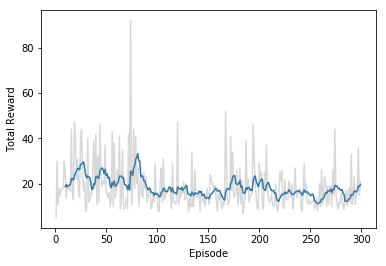

In [20]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')